# McKinney Chapter 11 - Practice - Sec 02

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf

In [2]:
%precision 4
pd.options.display.float_format = '{:.4f}'.format
%config InlineBackend.figure_format = 'retina'

## Announcements

1. Please propose and vote for students' choice topics [here](https://northeastern.instructure.com/courses/207607/discussion_topics/2622636) by Friday, 2/28, at 11:59 PM
2. Project 1 is due by Friday, 2/28, at 11:59 PM
    1. See the assignment [here](https://northeastern.instructure.com/courses/207607/assignments/2541687)
    2. Ask your questions [here](https://northeastern.instructure.com/courses/207607/discussion_topics/2708834)
    3. I will invite you to a peer review system---either Teammates or Feedback Fruits---as soon as I can

## Five-Minute Review

The time-series functionality in pandas is fantastic!
Here are the three main tools we will use:

1. `.shift()` method
    1. The `.shift()` method shifts the data in a series or data frame by a specified number of observations (or time periods with the `freq` argument).
    1. We will use it to get past or future (lagged or forward) characteristics, like returns, volatilities, or market capitalizations.
1. `.resample()` method
    1. The `.resample()` method resamples a series or data frame to decrease or increase its frequency (downsample or upsample).
    2. We will use it to calculate statistics (e.g., return means and standard deviations) for *non-overlapping windows*.
1. `.rolling()` method
    1. The `.rolling()` method performs rolling window calculations on a series or data frame.
    1. We will use it to calculate statistics (e.g., moving averages) for *overlapping windows*.

##  Practice

### Download daily returns for ten portfolios formed on book-to-market ratios

In [3]:
[i for i in pdr.famafrench.get_available_datasets() if ('BE-ME' in i) and ('Port' in i)][:5]

['Portfolios_Formed_on_BE-ME',
 'Portfolios_Formed_on_BE-ME_Wout_Div',
 'Portfolios_Formed_on_BE-ME_Daily',
 'Developed_6_Portfolios_ME_BE-ME',
 'Developed_6_Portfolios_ME_BE-ME_daily']

In [4]:
ff = pdr.DataReader(
    name='Portfolios_Formed_on_BE-ME_Daily',
    data_source='famafrench',
    start='1900'
)

C:\Users\r.herron\AppData\Local\Temp\ipykernel_18740\3411786515.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr.DataReader(
C:\Users\r.herron\AppData\Local\Temp\ipykernel_18740\3411786515.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr.DataReader(


With `data_source=famafrench`, `pdr.DataReader()` returns a dictionary of data frames.
The value for the `DESCR` key describes these data frames.

In [5]:
type(ff)

dict

In [6]:
print(ff['DESCR'])

Portfolios Formed on BE-ME Daily
--------------------------------

This file was created by CMPT_BEME_RETS_DAILY using the 202412 CRSP database. It contains value- and equal-weighted returns for portfolios formed on BE/ME. The portfolios are constructed at the end of June. BE/ME is book equity at the last fiscal year end of the prior calendar year divided by ME at the end of December of the prior year. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. The break points use Compustat firms plus the firms hand-collected from the Moodys Industrial, Utilities, Transportation, and Financial Manuals. The break points include utilities. The portfolios use Compustat firms plus the firms hand-collected from the Moodys Industrial, Utilities, Transportation, and Financial Manuals. The portfolios include utilities.

  0 : Value Weighted Returns -- Daily (25901 rows x 19 cols)
  1 : Equal Weighted Returns -- Daily (25901 rows x 19 cols)


In [7]:
bm = (
    ff[0]
    .iloc[:, -10:]
    .div(100)
    .rename_axis(columns='Portfolio')
)

### Plot cumulative returns for all available data

Exponential growth appears as a straight line on a logarithmic scale.
We will express cumulative returns as the value of a $1 investment to avoid issues with the logarithm of negative values, which is undefined.

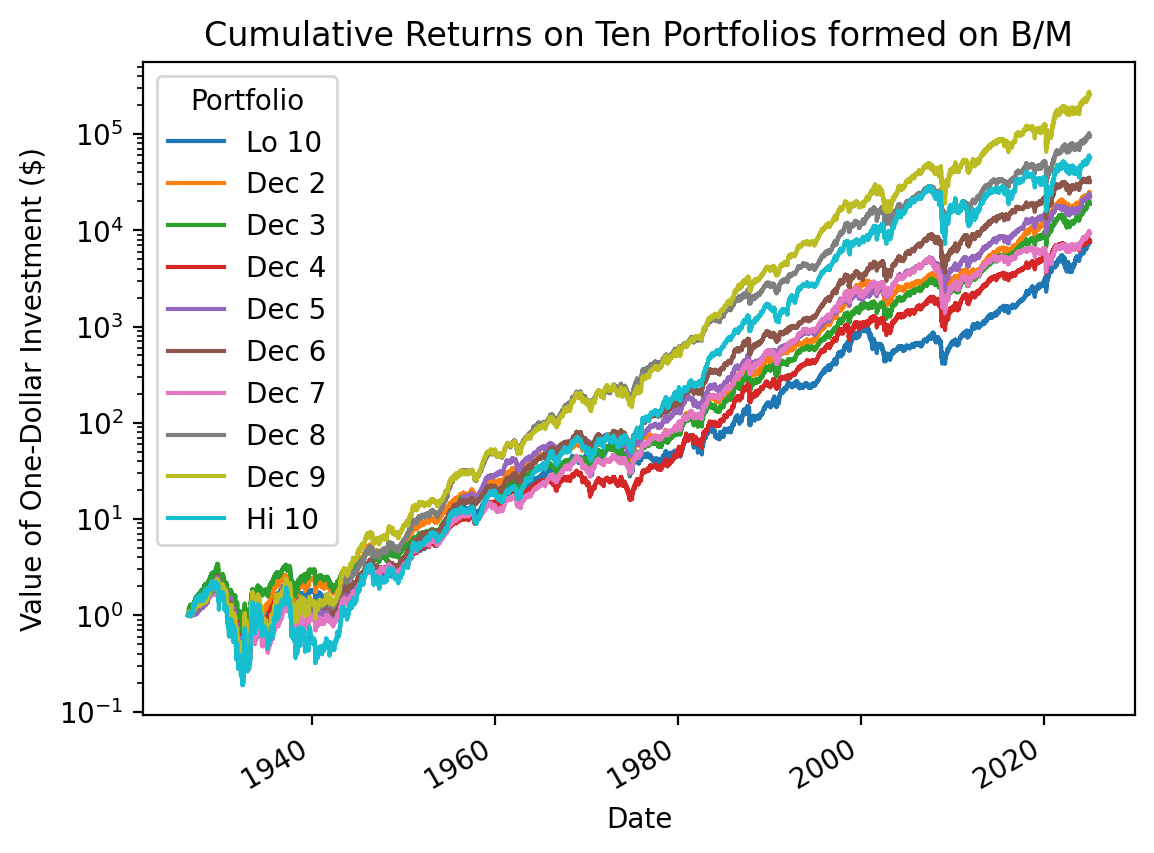

In [8]:
bm.add(1).cumprod().plot()

plt.ylabel('Value of One-Dollar Investment ($)')
plt.title('Cumulative Returns on Ten Portfolios formed on B/M')
plt.yscale('log')
plt.show()

### Calculate total returns for each calendar year

In [9]:
a = (  
    bm  
    .add(1)            # Convert simple returns into gross returns (1 + return)  
    .resample(rule='YE') # Resample data to yearly frequency ('YE' stands for Year-End), grouping by year  
    .prod()            # Compute the product of gross returns for each year to get total annual returns  
    .sub(1)            # Subtract 1 to convert gross returns back into simple returns  
)


In [10]:
a.head()

Portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10
Date,,,,,,,,,,
1926-12-31,0.0819,0.0309,0.2793,0.0899,0.0248,0.0825,0.1265,0.1038,0.0510,0.0958
1927-12-31,0.5773,0.2518,0.4298,0.2015,0.2041,0.2611,0.2832,0.2471,0.3844,0.4825
1928-12-31,0.4880,0.4965,0.3961,0.3724,0.4677,0.2581,0.1484,0.3331,0.3740,0.2668
1929-12-31,-0.2691,-0.0844,-0.1469,-0.0664,-0.0039,-0.0147,-0.0096,-0.0830,-0.0830,-0.2550
1930-12-31,-0.2911,-0.2067,-0.2679,-0.2757,-0.2531,-0.3514,-0.3858,-0.4110,-0.5280,-0.5669


### Calculate total returns for *all* 252-trading-day windows (i.e., rolling returns)

The following code calculates rolling total returns over 252-trading-day windows (approximately one year).
Since `.rolling()` does not have a built-in `.prod()`, we must use `.apply()` with a lambda function.
The lambda function transforms returns into gross returns (1 + return), computes the product over the window, and then subtracts 1 to express the result as a simple return.

Also, when using an integer `window` with `.rolling()`, the `min_periods` parameter defaults to the window size.
Here `window=252`, so calculations will only begin once the full 252-day window is available.

In [11]:
%%time
a = (
    bm
    .rolling(window=252)  # Rolling window of 252 trading days (approx. one year)
    .apply(lambda x: (1 + x).prod() - 1)  # No .prod() for .rolling(), so we use .apply() with a lambda
    # The lambda converts returns to gross returns (1 + return), takes the product, then subtracts 1
)

CPU times: total: 28.3 s
Wall time: 28.3 s


In [12]:
a

Portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10
Date,,,,,,,,,,
1926-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-07-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-07-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-07-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.4050,0.2251,0.3333,0.0983,0.2636,0.0363,0.2548,0.1525,0.2360,0.2177
2024-12-26,0.3997,0.2194,0.3257,0.0926,0.2599,0.0296,0.2510,0.1454,0.2216,0.2146
2024-12-27,0.3744,0.2032,0.3167,0.0830,0.2475,0.0228,0.2412,0.1322,0.2114,0.2014


The following code efficiently calculates rolling total returns over 252-trading-day windows by using log returns to improve computational speed.

1. Log transformation: `np.log1p(x)` applies the natural log to (1 + returns), converting simple returns into log returns. This makes summing returns equivalent to compounding them because the log of a product is the sum of the logs.
2. Summation: `.rolling(window=252).sum()` computes the sum of log returns over the rolling window. This is mathematically equivalent to taking the log of the total return.
3. Exponential transformation: `np.expm1(x)` reverses the log transformation, converting log total returns back into simple total returns.

The `.pipe()` method improves code readability.
It allows us to pass the series or data frame as the first argument to a function, avoiding the need for nested function calls.
We can use method chaining with `.pipe()`, making the code cleaner and easier to read.

In [13]:
%%time

b = (
    bm
    .pipe(np.log1p)  # Apply np.log1p(x), equivalent to np.log(1 + x), converting simple return to log return
    .rolling(window=252)  # Create a rolling window of 252 trading days (approx. one year)
    .sum()  # Sum log returns over the window to compute log total return
    .pipe(np.expm1)  # Apply np.expm1(x), equivalent to np.exp(x) - 1, converting log total return back to simple total return
)


CPU times: total: 15.6 ms
Wall time: 11.2 ms


In [14]:
b

Portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10
Date,,,,,,,,,,
1926-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-07-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-07-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-07-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.4050,0.2251,0.3333,0.0983,0.2636,0.0363,0.2548,0.1525,0.2360,0.2177
2024-12-26,0.3997,0.2194,0.3257,0.0926,0.2599,0.0296,0.2510,0.1454,0.2216,0.2146
2024-12-27,0.3744,0.2032,0.3167,0.0830,0.2475,0.0228,0.2412,0.1322,0.2114,0.2014


In [15]:
np.allclose(a=a, b=b, equal_nan=True)

True

### Calculate total returns for 12-months windows with monthly data

The following code calculates total returns over **12-month rolling windows** using **monthly data**, using an efficient log-return-based approach.

1. `np.log1p(x)` transforms simple returns into log returns, and all calculations remain in log-return space.
2. `.resample(rule='ME').sum()` downsamples the data from daily to monthly returns by summing log returns within each month.
3. `.rolling(window=12).sum()` applies a 12-month rolling window, summing the log returns over the past 12 months.
4. `np.expm1(x)` converts log total returns back to simple returns.

This log-returns-based approach, method avoids expensive multiplications and it much faster than a product-based approach.

In [16]:
a = (
    bm
    .pipe(np.log1p)  # Convert to log returns and stay in log returns for all calculations
    .resample(rule='ME')  # Downsample from daily to monthly returns 
    .sum()  # ...by summing log returns within each month
    .rolling(window=12)  # Apply a rolling 12-month window
    .sum()  # Sum log returns over the 12-month window to compute total log return
    .pipe(np.expm1)  # Convert back to simple returns
)

In [17]:
a

Portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10
Date,,,,,,,,,,
1926-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.3291,0.1739,0.2752,0.1209,0.3493,0.1576,0.2974,0.2579,0.3300,0.2854
2024-09-30,0.4477,0.2652,0.4019,0.1915,0.3747,0.2293,0.3351,0.3001,0.3626,0.3446
2024-10-31,0.4565,0.2712,0.4598,0.2394,0.4127,0.2464,0.3971,0.3464,0.4824,0.4768


### Calculate Sharpe Ratios for each calendar year

### Calculate rolling betas

We can calculate CAPM betas as: $\beta_i = \frac{Cov(r_i - r_f, r_M - r_f)}{Var(r_M - r_f)}$

### Calculate rolling Sharpe Ratios